In [11]:
%matplotlib inline

In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from matplotlib import gridspec

from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


In [13]:
def scatterplot(x, y, ex, ey, symbol, msize, xlabel, ylabel, 
                xlow, xhigh, ylow, yhigh, plotnumber, title, serieslabel):
    edge=0
    if symbol[0]=='y':
        edge=1
    plt.errorbar(x, y, xerr=ex, yerr=ey, fmt=symbol, markersize=msize, markeredgewidth=edge, label=serieslabel, capsize=0)
    plt.xlim(xlow, xhigh)
    plt.ylim(ylow, yhigh)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plotnumber.text(.08, .9, title, horizontalalignment='left', fontsize=15,
                    transform=plotnumber.transAxes)

def calcline(x1, x2, alpha, beta, lcolor):
    xdata = [x1, x2]
    ydata = [x1*alpha+beta, x2*alpha+beta]
    plt.plot(xdata, ydata, lcolor)
    
def quickstats(data):
    print 'Data, N, mean, median, stddev, min, max'
    print np.count_nonzero(~np.isnan(data)), \
        np.nanmean( data ),np.nanmedian( data ), np.nanstd(data), np.min(data), np.max(data)

## Equations and cosmology

In [14]:
# Derive R500 from M500 using Piffaretti's equation (3)
H0 = 70 # km/s / Mpc
Omega0 = 0.3
# G = 6.6720E-11 # N m^2/kg^2 = m^3 / (kg s^2)
# https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/constants.html
# Gravitational Constant 
G = 4.301E-9 # km^2 Mpc MSun^-1 s^-2 
Msun = 1.9891E30  # kg
parsec = 3.0856776E16 # m
#print np.pi
# EXAMPLE
z=1.0268        # redshift of whatever we want to check
M500 = 0. # 4.4E14 # Cluster mass in Msun
R500 = 0.722  # Cluster radius in Mpc, whichever is set to zero gets calculated
Hz = cosmo.H(z)
rho_c = cosmo.critical_density(z)

# convert rho_c to Msun / Mpc^3
rho_cMsun = rho_c * (parsec*100.)**3 / (Msun*1000.) * 1E6**3
#Hz = H0*(1+z)*(1+Omega0*z)**0.5
# Density will be in Msun / Mpc^3   ... this should be close enough
rho_calt = 3.*Hz**2 / (8*np.pi*G)

if R500==0:
    R500 = (3.* M500/(rho_cMsun*500.*4*np.pi))**(1./3.)
if M500==0:
    M500 = 4./3.*np.pi * R500**3 * rho_cMsun * 500.

print z, Hz, rho_c, rho_cMsun 
print rho_calt
print M500, R500

1.0268 125.202819939 km / (Mpc s) 2.94464357959e-29 g / cm3 4.34938408785e+11 g / cm3
4.35051002402e+11 km2 / (Mpc2 s2)
3.42845116413e+14 g / cm3 0.722


## Mahdavi et al 2013, 2014

In [15]:
# Read in data from Mahdavi et al 2013, 2014
df_mah1 = pd.read_csv('Mahdavi_revised_apj501003t1_ascii.csv',index_col=False)
df_mah2 = pd.read_csv('Mahdavi_apj464788t2_ascii.csv',index_col=False)

df_mahdavi = pd.merge(df_mah1, df_mah2, on='Cluster')
df_mahdavi['lM500Hydro'] = np.log10(df_mahdavi.M500Hydro)
df_mahdavi['lLXbol500'] = np.log10(df_mahdavi.LXbol500)
df_mahdavi['e_lM500Hydro'] = df_mahdavi.e_M500Hydro / df_mahdavi.M500Hydro /np.log(10.) 

# Read in Piffaretti et al. FITS table
d = fits.getdata('asu.fits')
df_piffaretti=pd.DataFrame(np.array(d).byteswap().newbyteorder())
df_piffaretti.columns = map(str.lower, df_piffaretti.columns)
#print df_piffaretti

#df_mahdavipiff = pd.merge(df_mahdavi,df_piffaretti, on='nrow')
#print df_mahdavipiff 

df_mahdavi['RA_deg'] = (df_mahdavi.RA_h + df_mahdavi.RA_m/60. + df_mahdavi.RA_s/3600.) * 15.
df_mahdavi['Dec_deg'] = (df_mahdavi.Dec_d + df_mahdavi.Dec_m/60. + df_mahdavi.Dec_s/3600.) 
#print df_mahdavi

In [16]:
# match those two dataframes on ra,dec  : RA_deg, Dec  and raj2000, dej2000
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=df_mahdavi.RA_deg*u.degree, dec=df_mahdavi.Dec_deg*u.degree)  
catalog = SkyCoord(ra=df_piffaretti.raj2000*u.degree, dec=df_piffaretti.dej2000*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog) 

from astropy.coordinates import match_coordinates_sky
idx, d2d, d3d = match_coordinates_sky(c, catalog) 

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, 0.0167*u.deg)
print idxcatalog

df_piffarettisel = df_piffaretti.iloc[idxcatalog]
df_mahdavisel = df_mahdavi.iloc[idxc]

df_mahdavisel = df_mahdavisel.reset_index(drop=True)
df_piffarettisel = df_piffarettisel.reset_index(drop=True)
#print df_mahdavisel
#print df_piffarettisel

# Stick them together in a simple join, suffixes need to be defined as there are columns in common
df_mahdaviall = df_mahdavisel.join(df_piffarettisel, lsuffix='_mahdavi', rsuffix='_piff')

# A959 : Pifferetti's redshift and therefore parameters are wrong
# Remove the line
df_mahdaviall = df_mahdaviall[df_mahdaviall.Cluster!='A0959']

#print df_mahdaviall

df_mahdaviall['Hz'] = cosmo.H(df_mahdaviall.z_mahdavi)
df_mahdaviall['lM500_calib'] = df_mahdaviall.lM500Hydro-0.0
df_mahdaviall['M500_calib'] = 10**df_mahdaviall.lM500_calib
df_mahdaviall['rho_c'] = 3.*df_mahdaviall.Hz**2 / (8*np.pi*G)
df_mahdaviall['R500_calib'] = (3.* df_mahdaviall.M500_calib * 1E14/(df_mahdaviall.rho_c*500.*4*np.pi))**(1./3.)
df_mahdaviall['lR500_calib'] = np.log10(df_mahdaviall.R500_calib)
df_mahdaviall['lL500_calib'] = 0.274 + 1.64 * (df_mahdaviall.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_mahdaviall.Hz/70.)
df_mahdaviall['L500_calib'] = 10 ** df_mahdaviall.lL500_calib


[1642 1367 1271 1174 1050 1431 1422 1555 1193 1416 1416 1275 1358 1054 1279
  951 1043 1276 1009 1254 1298 1686 1685 1125 1311 1514 1374 1572 1620 1675]


Data, N, mean, median, stddev, min, max
29 0.015026956679 -0.002735737817 0.144259084912 -0.309011681582 0.30761008296
Data, N, mean, median, stddev, min, max
29 -0.647205973549 -0.671119343204 0.134100311551 -0.953978411824 -0.33823250548


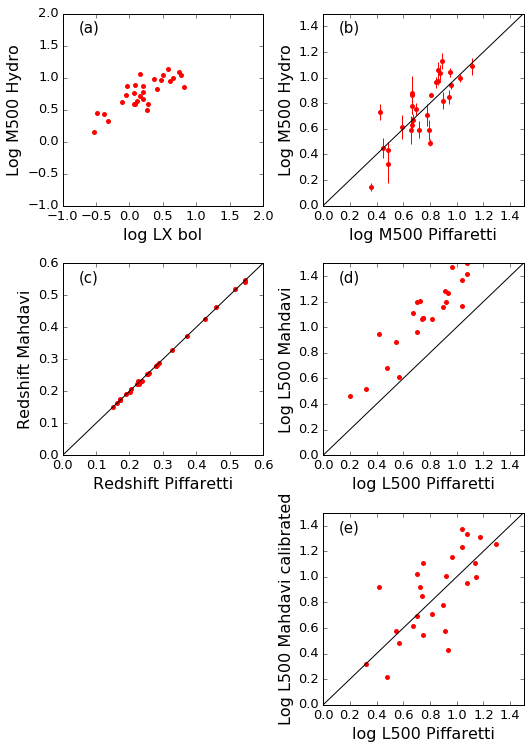

In [17]:
# Mahdavi: Test plot checking M500hydro vs LX
gs1 = gridspec.GridSpec(3,2)
gs1.update(left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(8,12))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])

ax1 = plt.subplot(gs1[0,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_mahdaviall.lLXbol500,df_mahdaviall.lM500Hydro, None, None, 'ro', 5, 
            'log LX bol', 'Log M500 Hydro', -1, 2, -1, 2, ax1, '(a)', 'Mahdavi')
#calcline(0, 2000, 1, 0, 'k')
# Must be some pretty straight forward MX-LX relation, so take M500 at face value as the M500 X-ray

# And when we do that, there is basically no offset
ax1 = plt.subplot(gs1[0,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_mahdaviall.lm500,df_mahdaviall.lM500Hydro, None, df_mahdaviall.e_lM500Hydro, 'ro', 5, 
            'log M500 Piffaretti', 'Log M500 Hydro', 0, 1.5, 0, 1.5, ax1, '(b)', 'Mahdavi')
calcline(0, 1.5, 1, 0, 'k')

# redshift check
ax1 = plt.subplot(gs1[1,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_mahdaviall.z_piff,df_mahdaviall.z_mahdavi, None, None, 'ro', 5, 
            'Redshift Piffaretti', 'Redshift Mahdavi', 0, 0.6, 0, 0.6, ax1, '(c)', 'redshift')
calcline(0, 0.6, 1, 0, 'k')

ax1 = plt.subplot(gs1[1,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

# Piffaretty uses L500/10^44, Mahdavi uses L500/10^45
scatterplot(df_mahdaviall.ll500,df_mahdaviall.lLXbol500+1., None, None, 'ro', 5, 
            'log L500 Piffaretti', 'Log L500 Mahdavi', 0, 1.5, 0, 1.5, ax1, '(d)', 'LumMahdavi')
calcline(0, 1.5, 1, 0, 'k')

ax1 = plt.subplot(gs1[2,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

# Piffaretti uses L500/10^44, Mahdavi uses L500/10^45
scatterplot(df_mahdaviall.ll500,df_mahdaviall.lL500_calib, None, None, 'ro', 5, 
            'log L500 Piffaretti', 'Log L500 Mahdavi calibrated', 0, 1.5, 0, 1.5, ax1, '(e)', 'LumMahdavi')
calcline(0, 1.5, 1, 0, 'k')


quickstats (df_mahdaviall.lM500Hydro - df_mahdaviall.lm500)
quickstats (df_mahdaviall.lLXbol500 - df_mahdaviall.ll500)

## Ettori et al 2009

In [18]:
# Read in data from Ettori et al 2009
df_ettori = pd.read_csv('Ettori2009_table1.csv',index_col=False)
#print df_ettori

In [19]:
df_ettori['Hz'] = cosmo.H(df_ettori.z)
df_ettori['rho_c'] = 3.*df_ettori.Hz**2 / (8*np.pi*G)
df_ettori['M500_ettori'] = 4./3.*np.pi * (df_ettori.R500_ettori/1000.)**3 * df_ettori.rho_c * 500. /1E14
df_ettori['e_M500_ettori'] = 4./3.*np.pi * 3* (df_ettori.e_R500_ettori/1000.)* (df_ettori.R500_ettori/1000.)**2 * \
    df_ettori.rho_c * 500. /1E14
df_ettori['lM500_ettori'] = np.log10(df_ettori.M500_ettori)
df_ettori['e_lM500_ettori'] = df_ettori.e_M500_ettori / df_ettori.M500_ettori / np.log(10.)
df_ettori['lM500'] = np.log10(df_ettori.M500)
#print df_ettori.head(n=10)
quickstats (df_ettori.lM500_ettori - df_ettori.lM500)

Data, N, mean, median, stddev, min, max
31 0.243510513838 0.294032070341 0.228109442848 -0.294857749064 0.595272533709


## Stott et al 2010

In [20]:
# Read in data from Stott et al 2010
df_stott = pd.read_csv('Stott_apj340771t1_ascii.csv',index_col=False)
#print df_stott

In [21]:
# Parameters for conversion of Tx to M500 Stott et al. 2010
lMstar = -0.57
alpha = 1.72
beta=-0.82
H0 = 70.
df_stott['Hz'] = cosmo.H(df_stott.z)
df_stott['lM500_stott'] = lMstar+alpha*np.log10(df_stott.TX)+beta*np.log10(df_stott.Hz/H0)
df_stott['lM200_stott'] = np.log10(df_stott.Mass)
print 'The offset ratio M200 / M500 used by Stott et al.'
print 10**(np.median(df_stott.lM200_stott - df_stott.lM500_stott))
df_stott['lM500'] = np.log10(df_stott.M500)
df_stott['e_lM500'] = ((df_stott.e_Massh+df_stott.e_Massl) / df_stott.Mass ) / np.log(10.)

quickstats (df_stott.lM500_stott - df_stott.lM500)

#print df_stott.Cluster, df_stott.lM500_stott - df_stott.lM500
df_stott['lM500_calib'] = df_stott.lM500_stott-0.176
df_stott['M500_calib'] = 10**df_stott.lM500_calib
df_stott['rho_c'] = 3.*df_stott.Hz**2 / (8*np.pi*G)
df_stott['R500_calib'] = (3.* df_stott.M500_calib * 1E14/(df_stott.rho_c*500.*4*np.pi))**(1./3.)
df_stott['lR500_calib'] = np.log10(df_stott.R500_calib)
#print df_stott
#df_stott.to_csv('Stott_apj340771t1_ascii_calib.csv',index_col=False)

The offset ratio M200 / M500 used by Stott et al.
1.35150187367
Data, N, mean, median, stddev, min, max
7 0.176270375466 0.270006548922 0.18925450239 -0.0971944793249 0.396853814148


## Pascut & Ponman 2015

In [22]:
# Pascut & Ponman 2015 MNRAS vol. 447 no. 4 3723-3744
# Read in data and merge into one table
df_pascuttable1 = pd.read_csv('pascut_Chandra_2015tab1.csv',index_col=False)
#print df_pascuttable1

df_pascuttable2 = pd.read_csv('pascut_Chandra_2015tab2.csv',index_col=False)
#print df_pascuttable2

df_pascut = pd.merge(df_pascuttable1, df_pascuttable2, on='ID')
#print df_pascut

# Read in Piffaretti et al. FITS table
d = fits.getdata('asu.fits')
df_piffaretti=pd.DataFrame(np.array(d).byteswap().newbyteorder())
df_piffaretti.columns = map(str.lower, df_piffaretti.columns)
df_piffaretti['lr500'] = np.log10(df_piffaretti.r500)
df_piffaretti['Hz'] = cosmo.H(df_piffaretti.z)
df_piffaretti['rho_c'] = 3.*df_piffaretti.Hz**2 / (8*np.pi*G)
df_piffaretti['Hz'] = df_piffaretti.Hz / 70.
# Attempt to back out the redshift dependent part of M500 - L500 relation to make sure I get this right
df_piffaretti['ll500_hz'] = df_piffaretti.ll500 - 7./3. * np.log10(df_piffaretti.Hz)
# log L500 from M500 as a check; M500 is in units of 10^14 Msun
df_piffaretti['ll500_flm500'] = 0.274 + 1.64 * (df_piffaretti.lm500 - np.log10(3.)) + \
    7./3. * np.log10(df_piffaretti.Hz)
df_piffaretti.columns
#print df_piffaretti.Hz

Index([u'recno', u'mcxc', u'oname', u'aname', u'raj2000', u'dej2000', u'z',
       u'cat', u'l500', u'm500', u'r500', u'notes', u'll500', u'lm500',
       u'nrow', u'lr500', u'Hz', u'rho_c', u'll500_hz', u'll500_flm500'],
      dtype='object')

In [23]:
# match those two dataframes on ra,dec  : RA_deg, Dec  and raj2000, dej2000
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=df_pascut.RA_deg*u.degree, dec=df_pascut.Dec*u.degree)  
catalog = SkyCoord(ra=df_piffaretti.raj2000*u.degree, dec=df_piffaretti.dej2000*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog) 

from astropy.coordinates import match_coordinates_sky
idx, d2d, d3d = match_coordinates_sky(c, catalog) 

idxc, idxcatalog, d2d, d3d = catalog.search_around_sky(c, 0.0167*u.deg)
print idxcatalog

df_piffarettisel = df_piffaretti.iloc[idxcatalog]
df_pascutsel = df_pascut.iloc[idxc]

df_pascutsel = df_pascutsel.reset_index(drop=True)
df_piffarettisel = df_piffarettisel.reset_index(drop=True)
#print df_pascutsel
#print df_piffarettisel

# Stick them together in a simple join, suffixes need to be defined as there are columns in common
df_pascutall = df_pascutsel.join(df_piffarettisel, lsuffix='_pascut', rsuffix='_piff')

# Estimate uncertainty on R500 by assuming average of upper/lower uncertainty on kT and coefficient of 0.53
df_pascutall['e_R500_pascut'] = 0.53 * (df_pascutall.e_kT_pascuth + df_pascutall.e_kT_pascutl)/2. \
    / df_pascutall.kT_pascut * df_pascutall.R500_pascut
# For plots below
df_pascutall['lR500_pascut'] = np.log10(df_pascutall.R500_pascut)
df_pascutall['lkT_pascut'] = np.log10(df_pascutall.kT_pascut)

# Derive M500
df_pascutall['Hz'] = cosmo.H(df_pascutall.z_pascut)
df_pascutall['rho_c'] = 3.*df_pascutall.Hz**2 / (8*np.pi*G)
df_pascutall['M500_pascut'] = 4./3.*np.pi * df_pascutall.R500_pascut**3 * df_pascutall.rho_c * 500./1E14
df_pascutall['e_M500_pascut'] = 4./3.*np.pi * 3* (df_pascutall.e_R500_pascut)* \
    (df_pascutall.R500_pascut)**2 * df_pascutall.rho_c * 500. /1E14
df_pascutall['lM500_pascut'] = np.log10(df_pascutall.M500_pascut)
df_pascutall['e_lM500_pascut'] = df_pascutall.e_M500_pascut / df_pascutall.M500_pascut / np.log(10.)
df_pascutall.columns
#print df_pascutall.lM500_pascut
#df_pascutall.head(n=5)
#print df_pascutall

# Pifferetti has entry for RXJ1415.1+3612 but redshift and parameters are wrong. Remove the line
df_pascutall = df_pascutall[df_pascutall.ID!='CDGS57']
#print df_pascutall.ID, df_pascutall.z_pascut, df_pascutall.z_piff, df_pascutall.mcxc

# Offset to consistency
df_pascutall['lM500_calib'] = df_pascutall.lM500_pascut - 0.08
df_pascutall['M500_calib'] = 10 ** df_pascutall.lM500_calib
# Derive R500
df_pascutall['R500_calib'] = (3.* df_pascutall.M500_calib * 1E14/(df_pascutall.rho_c*500.*4*np.pi))**(1./3.)
df_pascutall['lR500_calib'] = np.log10(df_pascutall.R500_calib)
# Derive log L500 from M500; M500 is in units of 10^14 Msun  Equation (2) from Piffaretti et al. H0=70
df_pascutall['lL500_calib'] = 0.274 + 1.64 * (df_pascutall.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_pascutall.Hz/70.)
df_pascutall['L500_calib'] = 10 ** df_pascutall.lL500_calib


[1260 1335 1554 1604 1635 1641 1642 1644 1663 1686 1695 1699 1707 1705 1721
 1726 1727 1728 1731 1725 1742]


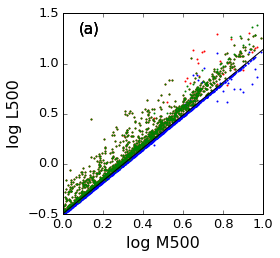

In [24]:
# Test plot of ll500 lm500 from Piffaretti - checking the relation in paper
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(8,8))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])

ax1 = plt.subplot(gs1[0,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_piffaretti.lm500,df_piffaretti.ll500, None, None, 'ro', 2, 
            'log M500', 'log L500', 0, 1, -0.5, 1.5, ax1, '(a)', 'Piff')
scatterplot(df_piffaretti.lm500,df_piffaretti.ll500_hz, None, None, 'bo', 2, 
            'log M500', 'log L500', 0, 1, -0.5, 1.5, ax1, '(a)', 'Piff')
scatterplot(df_piffaretti.lm500,df_piffaretti.ll500_flm500, None, None, 'go', 2, 
            'log M500', 'log L500', 0, 1, -0.5, 1.5, ax1, '(a)', 'Piff')
calcline(0, 1, 1.64, -0.5, 'k')

Data, N, mean, median, stddev, min, max
20 0.0826842480065 0.07637315248 0.129850395391 -0.129974859337 0.326381231752


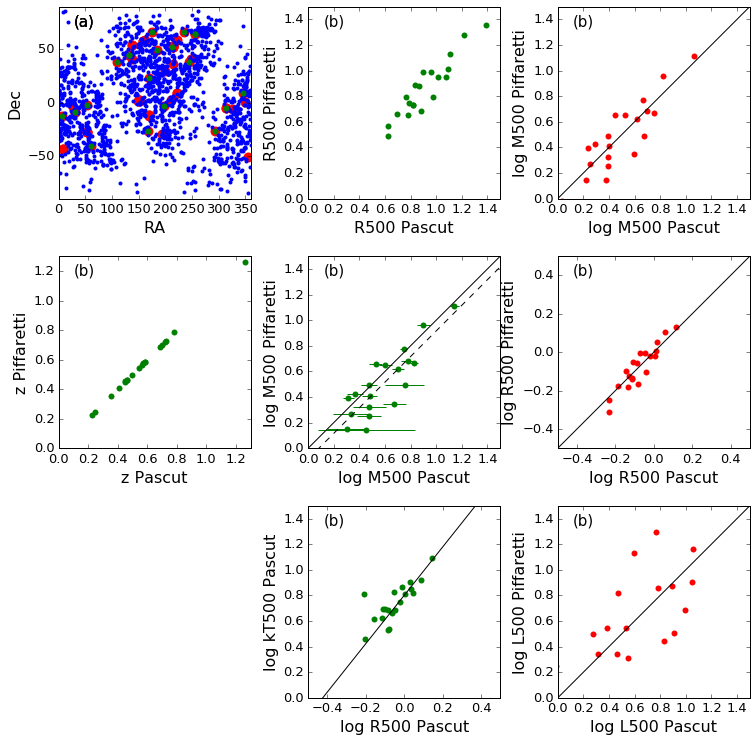

In [25]:
# Test plot of ra,dec from those tables above
gs1 = gridspec.GridSpec(3,3)
gs1.update(left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(12,12))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])

ax1 = plt.subplot(gs1[0,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_pascut.RA_deg,df_pascut.Dec, None, None, 'ro', 10, 
            'RA', 'Dec', 0, 360, -90, 90, ax1, '(a)', 'Pascut')
scatterplot(df_piffaretti.raj2000,df_piffaretti.dej2000, None, None, 'bo', 4, 
            'RA', 'Dec', 0, 360, -90, 90, ax1, '(a)', 'Piffaretti')
scatterplot(df_pascutall.raj2000,df_pascutall.dej2000, None, None, 'go', 6, 
            'RA', 'Dec', 0, 360, -90, 90, ax1, '(a)', 'Piffaretti')

ax1 = plt.subplot(gs1[1,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.z_pascut,df_pascutall.z_piff, None, None, 'go', 6, 
            'z Pascut', 'z Piffaretti', 0, 1.3, 0, 1.3, ax1, '(b)', 'redshift')

ax1 = plt.subplot(gs1[2,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.lR500_pascut,df_pascutall.lkT_pascut, None, None, 'go', 6, 
            'log R500 Pascut', 'log kT500 Pascut', -0.5, 0.5, 0, 1.5, ax1, '(b)', 'kT')
calcline(-0.5, 0.5, 1./0.53, 0.8, 'k')


ax1 = plt.subplot(gs1[0,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.R500_pascut,df_pascutall.r500, None, None, 'go', 6, 
            'R500 Pascut', 'R500 Piffaretti', 0, 1.5, 0, 1.5, ax1, '(b)', 'R500')

ax1 = plt.subplot(gs1[1,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.lM500_pascut,df_pascutall.lm500, df_pascutall.e_lM500_pascut, None, 'go', 6, 
            'log M500 Pascut', 'log M500 Piffaretti', 0, 1.5, 0, 1.5, ax1, '(b)', 'lM500')
calcline(0, 1.5, 1, 0., 'k')
calcline(0, 1.5, 1, -0.084, 'k--')

ax1 = plt.subplot(gs1[0,2])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.lM500_calib,df_pascutall.lm500, None, None, 'ro', 6, 
            'log M500 Pascut', 'log M500 Piffaretti', 0, 1.5, 0, 1.5, ax1, '(b)', 'lM500')
calcline(0, 1.5, 1, 0., 'k')
#calcline(0, 1.5, 1, -0.084, 'k--')

ax1 = plt.subplot(gs1[1,2])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.lR500_calib,df_pascutall.lr500, None, None, 'ro', 6, 
            'log R500 Pascut', 'log R500 Piffaretti', -0.5, 0.5, -0.5, 0.5, ax1, '(b)', 'R500')
calcline(-0.5, 0.5, 1, 0., 'k')

ax1 = plt.subplot(gs1[2,2])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)
scatterplot(df_pascutall.lL500_calib,df_pascutall.ll500, None, None, 'ro', 6, 
            'log L500 Pascut', 'log L500 Piffaretti', 0, 1.5, 0, 1.5, ax1, '(b)', 'L500')
calcline(0, 15., 1, 0., 'k')

quickstats (df_pascutall.lM500_pascut - df_pascutall.lm500)

## Publication plot of comparisons

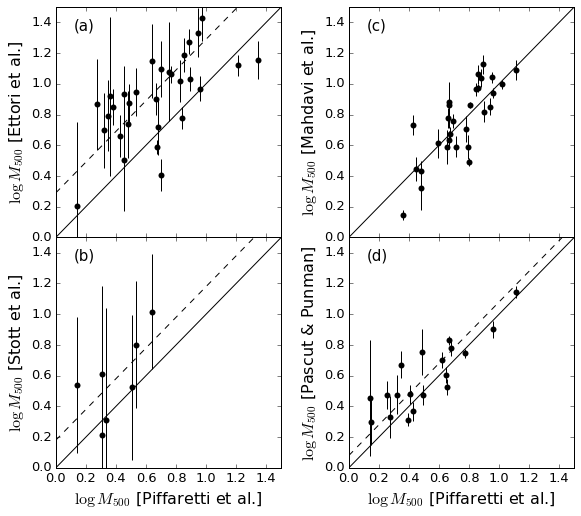

In [26]:
gs1 = gridspec.GridSpec(2,2)
gs1.update(left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.3, hspace=0.0)
fig = plt.figure(figsize=(9,8))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])

ax1 = plt.subplot(gs1[0,0])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_ettori.lM500,df_ettori.lM500_ettori, None, df_ettori.e_lM500_ettori, 'ko', 6, 
            '', r'$\log\, M_{\rm 500}$ [Ettori et al.]', 0, 1.5, 0, 1.5, ax1, '(a)', 'Ettori')
calcline(0, 1.5, 1, 0, 'k')
calcline(0, 1.5, 1, 0.29, 'k--')

ax1 = plt.subplot(gs1[1,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_stott.lM500,df_stott.lM500_stott, None, df_stott.e_lM500, 'ko', 6, 
            r'$\log\, M_{\rm 500}$ [Piffaretti et al.]', r'$\log\, M_{\rm 500}$ [Stott et al.]', 
            0, 1.5, 0, 1.5, ax1, '(b)', 'Stott')

calcline(0, 1.5, 1, 0., 'k')
calcline(0, 1.5, 1, 0.18, 'k--')

ax1 = plt.subplot(gs1[0,1])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_mahdaviall.lm500,df_mahdaviall.lM500Hydro, None, df_mahdaviall.e_lM500Hydro, 'ko', 6, 
            r'$\log\, M_{\rm 500}$ [Piffaretti et al.]', r'$\log\, M_{\rm 500}$ [Mahdavi et al.]', 
            0, 1.5, 0, 1.5, ax1, '(c)', 'Mahdavi')
calcline(0, 1.5, 1, 0, 'k')
#calcline(0, 1.5, 1, -0.01, 'k--')

ax1 = plt.subplot(gs1[1,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_pascutall.lm500, df_pascutall.lM500_pascut, None, df_pascutall.e_lM500_pascut, 'ko', 6, 
            r'$\log\, M_{\rm 500}$ [Piffaretti et al.]', r'$\log\, M_{\rm 500}$ [Pascut & Punman]', 
            0, 1.5, 0, 1.5, ax1, '(d)', 'Pascut')

calcline(0, 1.5, 1, 0., 'k')
calcline(0, 1.5, 1, 0.08, 'k--')


plt.savefig('XrayM500_calib.eps', format="eps")


## Calibration of each of the original input tables
Adopted offsets:

log M500 calib = log M500 Ettori  - 0.29

log M500 calib = log M500 Stott  - 0.18

log M500 calib = log M500 Mahdavi  - 0.00

log M500 calib = log M500 Pascut  - 0.08

Then R500 is calculated from that, L500 estimated from that


In [27]:
# Derive M500
df_ettori['Hz'] = cosmo.H(df_ettori.z)
df_ettori['rho_c'] = 3.*df_ettori.Hz**2 / (8*np.pi*G)
df_ettori['M500_ettori'] = 4./3.*np.pi * (df_ettori.R500_ettori/1000.)**3 * df_ettori.rho_c * 500./1E14
df_ettori['e_M500_ettori'] = 4./3.*np.pi * 3* (df_ettori.e_R500_ettori)* \
    (df_ettori.R500_ettori)**2 * df_ettori.rho_c * 500. /1E14
df_ettori['lM500_ettori'] = np.log10(df_ettori.M500_ettori)
df_ettori['e_lM500_ettori'] = df_ettori.e_M500_ettori / df_ettori.M500_ettori / np.log(10.)

# Offset to consistency
df_ettori['lM500_calib'] = df_ettori.lM500_ettori - 0.29
df_ettori['M500_calib'] = 10 ** df_ettori.lM500_calib
# Derive R500
df_ettori['R500_calib'] = (3.* df_ettori.M500_calib * 1E14/(df_ettori.rho_c*500.*4*np.pi))**(1./3.)
df_ettori['lR500_calib'] = np.log10(df_ettori.R500_calib)
# Derive log L500 from M500; M500 is in units of 10^14 Msun  Equation (2) from Piffaretti et al. H0=70
df_ettori['lL500_calib'] = 0.274 + 1.64 * (df_ettori.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_ettori.Hz/70.)
df_ettori['L500_calib'] = 10 ** df_ettori.lL500_calib

#print df_ettori.Cluster
df_ettori.to_csv('Ettori_calib.csv',index_col=False)
df_ettori_select = df_ettori[(df_ettori.Cluster=='RXJ1716.4+6708') | (df_ettori.Cluster=='RXJ0152.7-1357S') |\
                              (df_ettori.Cluster=='RXJ0152.7-1357N') |\
                              (df_ettori.Cluster=='CL1415.1+3612') | (df_ettori.Cluster=='RDCSJ1252-2927') |\
                              (df_ettori.Cluster=='RDCSJ0849+4452') | (df_ettori.Cluster=='RDCSJ0848+4453')]

#print df_ettori_select
df_ettori_select = df_ettori_select.ix[:,['Cluster','z','lM500_calib','M500_calib','R500_calib','lR500_calib','lL500_calib','L500_calib']]
df_ettori_select.Cluster = df_ettori_select.Cluster.replace('CL1415.1+3612', 'RXJ1415.1+3612')
df_ettori_select.Cluster = df_ettori_select.Cluster.replace('RDCSJ1252-2927', 'RXJ1252.9-2927')
df_ettori_select.Cluster = df_ettori_select.Cluster.replace('RDCSJ0849+4452', 'RXJ0848.9+4452')
df_ettori_select.Cluster = df_ettori_select.Cluster.replace('RDCSJ0848+4453', 'RXJ0848.6+4453')
print df_ettori_select

            Cluster      z  lM500_calib  M500_calib  R500_calib  lR500_calib  \
42   RXJ1716.4+6708  0.813     0.429030    2.685531    0.723605    -0.140498   
43  RXJ0152.7-1357S  0.828     0.935899    8.627788    1.061395     0.025877   
45  RXJ0152.7-1357N  0.835     0.538893    3.458541    0.780437    -0.107662   
47   RXJ1415.1+3612  1.030     0.618019    4.149725    0.768430    -0.114395   
49   RXJ1252.9-2927  1.235     0.234739    1.716878    0.529897    -0.275809   
50   RXJ0848.9+4452  1.261    -0.087519    0.817487    0.409830    -0.387397   
51   RXJ0848.6+4453  1.273    -0.232687    0.585212    0.365004    -0.437702   

    lL500_calib  L500_calib  
42     0.657082    4.540273  
43     1.497382   31.432743  
45     0.850503    7.087670  
47     1.096152   12.478194  
49     0.585359    3.849096  
50     0.071444    1.178812  
51    -0.159924    0.691951  


In [28]:
# Stott et al
#print df_stott.Cluster, df_stott.lM500_stott - df_stott.lM500
df_stott['lM500_calib'] = df_stott.lM500_stott-0.18
df_stott['M500_calib'] = 10**df_stott.lM500_calib
df_stott['rho_c'] = 3.*df_stott.Hz**2 / (8*np.pi*G)
df_stott['R500_calib'] = (3.* df_stott.M500_calib * 1E14/(df_stott.rho_c*500.*4*np.pi))**(1./3.)
df_stott['lR500_calib'] = np.log10(df_stott.R500_calib)
df_stott['lL500_calib'] = 0.274 + 1.64 * (df_stott.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_stott.Hz/70.)
df_stott['L500_calib'] = 10 ** df_stott.lL500_calib
#print df_stott
df_stott.to_csv('Stott_apj340771t1_ascii_calib.csv',index_col=False)

# Extract only the relavant pieces

df_stott_select = df_stott[(df_stott.Cluster=='WARPS_J1415.1+3612') | (df_stott.Cluster=='RDCS_J1252.9-2927') | \
                           (df_stott.Cluster=='RX_J0848.9+4452') | (df_stott.Cluster=='XMMU_J2235.3-2557') | \
                           (df_stott.Cluster=='XMMXCS_J2215.9-1738')]

#print df_stott_select
df_stott_select = df_stott_select.ix[:,['Cluster','z','lM500_calib','M500_calib','R500_calib','lR500_calib','lL500_calib','L500_calib']]
print df_stott_select

# this first way of doing it gives a warning about copies and slices ...
#df_stott_select.Cluster[df_stott_select.Cluster=='WARPS_J1415.1+3612'] = 'RXJ1415.1+3612'
df_stott_select.Cluster = df_stott_select.Cluster.replace('WARPS_J1415.1+3612', 'RXJ1415.1+3612')
df_stott_select.Cluster = df_stott_select.Cluster.replace('RDCS_J1252.9-2927', 'RXJ1252.9-2927')
df_stott_select.Cluster = df_stott_select.Cluster.replace('RX_J0848.9+4452', 'RXJ0848.9+4452')

df_stott_select.Cluster = df_stott_select.Cluster.replace('XMMU_J2235.3-2557', 'XMM2235.3-2557')
df_stott_select.Cluster = df_stott_select.Cluster.replace('XMMXCS_J2215.9-1738', 'XMM2215.9-1738')

print df_stott_select

                Cluster     z  lM500_calib  M500_calib  R500_calib  \
12   WARPS_J1415.1+3612  1.03     0.405192    2.542095    0.652622   
16    RDCS_J1252.9-2927  1.24     0.474508    2.982004    0.635786   
17      RX_J0848.9+4452  1.26     0.358868    2.284902    0.577509   
18    XMMU_J2235.3-2557  1.39     0.578093    3.785232    0.651849   
19  XMMXCS_J2215.9-1738  1.46     0.011488    1.026804    0.411625   

    lR500_calib  lL500_calib  L500_calib  
12    -0.185338     0.747114    5.586173  
16    -0.196689     0.981392    9.580580  
17    -0.238441     0.802959    6.352715  
18    -0.185853     1.234192   17.147149  
19    -0.385499     0.342680    2.201303  
           Cluster     z  lM500_calib  M500_calib  R500_calib  lR500_calib  \
12  RXJ1415.1+3612  1.03     0.405192    2.542095    0.652622    -0.185338   
16  RXJ1252.9-2927  1.24     0.474508    2.982004    0.635786    -0.196689   
17  RXJ0848.9+4452  1.26     0.358868    2.284902    0.577509    -0.238441   
18  XMM22

In [29]:
# Mahdavi et al
df_mahdavi['Hz'] = cosmo.H(df_mahdavi.z)
df_mahdavi['lM500_calib'] = df_mahdavi.lM500Hydro-0.0
df_mahdavi['M500_calib'] = 10**df_mahdavi.lM500_calib
df_mahdavi['rho_c'] = 3.*df_mahdavi.Hz**2 / (8*np.pi*G)
df_mahdavi['R500_calib'] = (3.* df_mahdavi.M500_calib * 1E14/(df_mahdavi.rho_c*500.*4*np.pi))**(1./3.)
df_mahdavi['lR500_calib'] = np.log10(df_mahdavi.R500_calib)
df_mahdavi['lL500_calib'] = 0.274 + 1.64 * (df_mahdavi.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_mahdavi.Hz/70.)
df_mahdavi['L500_calib'] = 10 ** df_mahdavi.lL500_calib
#print df_mahdavi
df_mahdavi.to_csv('mahdavi_calib.csv',index_col=False)

# Extract only the relavant pieces

df_mahdavi_select = df_mahdavi[(df_mahdavi.Cluster=='A0115N') | (df_mahdavi.Cluster=='A0115S')]

#                          (df_mahdavi.Cluster=='A0851') | (df_mahdavi.Cluster=='RXJ1347.5-1145')]

#print df_mahdavi_select
df_mahdavi_select = df_mahdavi_select.ix[:,['Cluster','z','lM500_calib','M500_calib','R500_calib','lR500_calib','lL500_calib','L500_calib']]
print df_mahdavi_select

  Cluster      z  lM500_calib  M500_calib  R500_calib  lR500_calib  \
2  A0115N  0.197     0.612784         4.1    1.058262     0.024593   
3  A0115S  0.197     0.623249         4.2    1.066797     0.028082   

   lL500_calib  L500_calib  
2     0.594997    3.935473  
3     0.612160    4.094117  


In [30]:
# Pascut & Punman: Derive M500
# Estimate uncertainty on R500 by assuming average of upper/lower uncertainty on kT and coefficient of 0.53
df_pascut['e_R500_pascut'] = 0.53 * (df_pascut.e_kT_pascuth + df_pascut.e_kT_pascutl)/2. \
    / df_pascut.kT_pascut * df_pascut.R500_pascut    
df_pascut['Hz'] = cosmo.H(df_pascut.z)
df_pascut['rho_c'] = 3.*df_pascut.Hz**2 / (8*np.pi*G)
df_pascut['M500_pascut'] = 4./3.*np.pi * df_pascut.R500_pascut**3 * df_pascut.rho_c * 500./1E14
df_pascut['e_M500_pascut'] = 4./3.*np.pi * 3* (df_pascut.e_R500_pascut)* \
    (df_pascut.R500_pascut)**2 * df_pascut.rho_c * 500. /1E14
df_pascut['lM500_pascut'] = np.log10(df_pascut.M500_pascut)
df_pascut['e_lM500_pascut'] = df_pascut.e_M500_pascut / df_pascut.M500_pascut / np.log(10.)

# Offset to consistency
df_pascut['lM500_calib'] = df_pascut.lM500_pascut - 0.08
df_pascut['M500_calib'] = 10 ** df_pascut.lM500_calib
# Derive R500
df_pascut['R500_calib'] = (3.* df_pascut.M500_calib * 1E14/(df_pascut.rho_c*500.*4*np.pi))**(1./3.)
df_pascut['lR500_calib'] = np.log10(df_pascut.R500_calib)
# Derive log L500 from M500; M500 is in units of 10^14 Msun  Equation (2) from Piffaretti et al. H0=70
df_pascut['lL500_calib'] = 0.274 + 1.64 * (df_pascut.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_pascut.Hz/70.)
df_pascut['L500_calib'] = 10 ** df_pascut.lL500_calib

df_pascut.to_csv('Pascut_Chandra_calib.csv',index_col=False)
# Extract only the relavant pieces
#df_pascut_select = df_pascut[df_pascut.ID=='CDGS59']
df_pascut_select = df_pascut[(df_pascut.ID=='CDGS57') | (df_pascut.ID=='CDGS60') | (df_pascut.ID=='CDGS61') | (df_pascut.ID=='CDGS62')]

#print df_pascut_select
df_pascut_select = df_pascut_select.ix[:,['ID','Literature_names','z','lM500_calib','M500_calib','R500_calib','lR500_calib','lL500_calib','L500_calib']]
df_pascut_select['Cluster'] = df_pascut_select.Literature_names
df_pascut_select.Cluster = df_pascut_select.Cluster.replace('WARPSJ1415.1+3612', 'RXJ1415.1+3612')
df_pascut_select.Cluster = df_pascut_select.Cluster.replace('RDCS1252-29', 'RXJ1252.9-2927')
df_pascut_select.Cluster = df_pascut_select.Cluster.replace('RXJ0848.9+4452_RDCS0848.9+4452', 'RXJ0848.9+4452')
df_pascut_select.Cluster = df_pascut_select.Cluster.replace('RXJ0848.6+4453_RDCS0848.6+4453_CLGJ0848+4453', 'RXJ0848.6+4453')
print df_pascut_select


        ID                              Literature_names      z  lM500_calib  \
56  CDGS57                             WARPSJ1415.1+3612  1.026     0.454809   
59  CDGS60                                   RDCS1252-29  1.237     0.449634   
60  CDGS61                RXJ0848.9+4452_RDCS0848.9+4452  1.261     0.373946   
61  CDGS62  RXJ0848.6+4453_RDCS0848.6+4453_CLGJ0848+4453  1.273    -0.440097   

    M500_calib  R500_calib  lR500_calib  lL500_calib  L500_calib  \
56    2.849762    0.679001    -0.168129     0.826142    6.701044   
59    2.816009    0.624455    -0.204499     0.938911    8.687831   
60    2.365624    0.584016    -0.233575     0.828247    6.733594   
61    0.362997    0.311287    -0.506839    -0.500078    0.316171   

           Cluster  
56  RXJ1415.1+3612  
59  RXJ1252.9-2927  
60  RXJ0848.9+4452  
61  RXJ0848.6+4453  


## Conversions between LX 0.2-5.0keV, LX 0.1-2.4keV, LX bol
From Bohringer et al 2004, A&A, 425, 367 Table 4 and 5

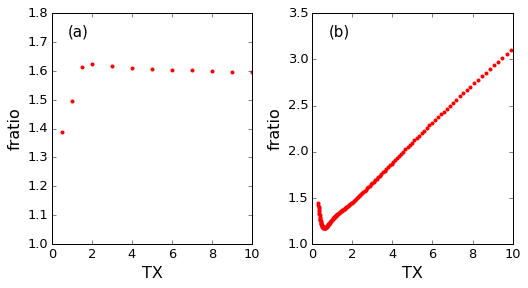

In [67]:
# The calibration tables + quick plots
df_bohtab4 = pd.read_csv('Bohringer2004_table4.csv',index_col=False)
df_bohtab5 = pd.read_csv('Bohringer2004_table5.csv',index_col=False)

# Test plot of ra,dec from those tables above
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(8,4))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])

ax1 = plt.subplot(gs1[0,0])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_bohtab4.TX,df_bohtab4.fratio, None, None, 'ro', 4, 
            'TX', 'fratio', 0, 10, 1., 1.8, ax1, '(a)', '01to24')

ax1 = plt.subplot(gs1[0,1])
plt.setp(ax1.get_xticklabels(), fontsize=13)
plt.setp(ax1.get_yticklabels(), fontsize=13)

scatterplot(df_bohtab5.TX,df_bohtab5.fratio, None, None, 'ro', 4, 
            'TX', 'fratio', 0, 10, 1., 3.5, ax1, '(b)', 'bol')



## Two missing clusters
J1438.1+3414 z=1.413 Brodwin et al. 2011, ApJ, 732, 33:  log M500 = 14.17 +0.11 - 0.14  Derived from a Lx-Mass relation but with cosmology  H0 =70.2; Omega_M = 0.272 ; Omega_L = 0.728

J0332=2742 z=1.610 Kurk et al 2009, A&A, 504, 331: Derives M_vir=9 10^13 Msun and R200=0.5 Mpc from sigma_cluster = 400 km/s +95 -60. But has Lx,bol=21.1*10^34 erg/sec 

In [69]:
# With Brodwin's chosen cosmology the luminosity at z=1.41 needs to be corrected with
Lcorr = (10106./10291.4)**3

# Our choice of cosmoligy
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Derive R500 from M500 using Piffaretti's equation (3)
H0 = 70. # km/s / Mpc
Omega0 = 0.3
# G = 6.6720E-11 # N m^2/kg^2 = m^3 / (kg s^2)
# https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/constants.html
# Gravitational Constant 
G = 4.301E-9 # km^2 Mpc MSun^-1 s^-2 
Msun = 1.9891E30  # kg
parsec = 3.0856776E16 # m
#print np.pi
# EXAMPLE
z=1.41        # redshift of whatever we want to check
# L500 corrected for difference in cosmology and corrected to 0.1-2.4keV band
L500 = 1E44*Lcorr*1.62 # Cluster LX in erg/sec
M500 = 0. # 10 ** 14.17 # 4.4E14 # Cluster mass in Msun
R500 = 0. # Cluster radius in Mpc, whichever is set to zero gets calculated
Hz = cosmo.H(z)/cosmo.H(0)
rho_c = cosmo.critical_density(z)

# convert rho_c to Msun / Mpc^3
rho_cMsun = rho_c * (parsec*100.)**3 / (Msun*1000.) * 1E6**3
#Hz = H0*(1+z)*(1+Omega0*z)**0.5
# Density will be in Msun / Mpc^3   ... this should be close enough
rho_calt = 3.*(Hz*H0)**2 / (8*np.pi*G)

if L500==0:
    L500 = 10**0.274 * (M500/(3E14))**1.64 *(Hz)**(7./3.)
if M500==0:
    M500 =  ((Hz)**(-7./3.) * L500/1E44 / 10**0.274 ) ** (1./1.64) * (3E14)
if R500==0:
    R500 = (3.* M500/(rho_cMsun*500.*4*np.pi))**(1./3.)
if M500==0:
    M500 = 4./3.*np.pi * R500**3 * rho_cMsun * 500.

print z, Hz, rho_c, rho_cMsun, Lcorr
print rho_calt
print L500, M500, R500, np.log10(M500)

# set it back to avoid confusion
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

1.41 2.21405661479 4.51209295155e-29 g / cm3 6.66458427173e+11 g / cm3 0.946922653492
6.66630954968e+11
1.53401469866e+44 8.55532677429e+13 0.394277179917 cm / g(1/3) 13.9322366023


In [71]:
# Kurk et al 2009, A&A, 504, 331: Using Lxbol  
# J0332-2742 z=1.610  Derives M_vir=9 10^13 Msun and R200=0.5 Mpc from sigma_cluster = 400 km/s +95 -60. 
# But has a limit in X-ray luminosity at Lx,bol=21.1*10^34 erg/sec, assuming TX=2KeV
# We adopt thier measure of R200 and derive estimates of the rest using the same equations as above
# Our choice of cosmoligy
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Derive R500 from M500 using Piffaretti's equation (3)
H0 = 70. # km/s / Mpc
Omega0 = 0.3
# G = 6.6720E-11 # N m^2/kg^2 = m^3 / (kg s^2)
# https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/constants.html
# Gravitational Constant 
G = 4.301E-9 # km^2 Mpc MSun^-1 s^-2 
Msun = 1.9891E30  # kg
parsec = 3.0856776E16 # m
#print np.pi
# EXAMPLE
z=1.61        # redshift of whatever we want to check
# L500 corrected for difference in cosmology and corrected to 0.1-2.4keV band
L500 = 0. # Cluster LX in erg/sec
M500 = 0. # 10 ** 14.17 # 4.4E14 # Cluster mass in Msun
R500 = 0.5/1.52 # Cluster radius in Mpc, whichever is set to zero gets calculated
Hz = cosmo.H(z)/cosmo.H(0)
rho_c = cosmo.critical_density(z)

# convert rho_c to Msun / Mpc^3
rho_cMsun = rho_c * (parsec*100.)**3 / (Msun*1000.) * 1E6**3
#Hz = H0*(1+z)*(1+Omega0*z)**0.5
# Density will be in Msun / Mpc^3   ... this should be close enough
rho_calt = 3.*(Hz*H0)**2 / (8*np.pi*G)

if M500==0:
    M500 = 4./3.*np.pi * R500**3 * rho_cMsun * 500.
if L500==0:
    L500 = 10**0.274 * (M500/(3E14))**1.64 *(Hz)**(7./3.)
#if M500==0:
#    M500 =  ((Hz)**(-7./3.) * L500/1E44 / 10**0.274 ) ** (1./1.64) * (3E14)
if R500==0:
    R500 = (3.* M500/(rho_cMsun*500.*4*np.pi))**(1./3.)

print z, Hz, rho_c, rho_cMsun
print rho_calt
print L500, M500, R500

# set it back to avoid confusion
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

 1.61 2.45718228841 5.55744721583e-29 g / cm3 8.20862418023e+11 g / cm3
8.21074916774e+11
1.12912804086 g(13/8) / cm(49/10) 6.11939145038e+13 g / cm3 0.328947368421


## Merging the calibrated tables
Derive average lM500, then rederive R500 and L500 from that

    df_ettori_select: RXJ1716, RXJ0152S, RXJ0152N, RXJ1415, Lynx E, Lynx W, RXJ1252
    df_stott_select: RXJ1415, RXJ1252, Lynx E, XMM2235, XMM2215
    df_mahdavi_select: A115N, A115S
    df_pascut_select: RXJ1415, RXJ1252, Lynx E, Lynx W
    
    ISCS J1438.1+3414 at z=1.41 from Brodwin et al (see above) 
        L500 = 1.534 * 10^44 erg/sec
        M500 = 0.855 * 10^14 Msun
        R500 = 0.394 Mpc
        
    J0332=2742 z=1.610 Kurk et al 2009, A&A, 504, 331: (see above)
        L500 = 1.130 * 10^44 erg/sec
        M500 = 0.612 * 10^14 Msun
        R500 = 0.329 Mpc Mpc 

In [74]:
# Make a data frame with homogeneous cluster names & redshift, then use that to merge them all on the cluster name

df_clusternames = df_ettori_select.ix[:,['Cluster','z']]
df_tmp1 = df_mahdavi_select.ix[:,['Cluster','z']]
df_tmp2 = df_stott_select.ix[[18,19],['Cluster','z']]

df_clusternames = df_tmp1.append(df_clusternames, ignore_index=True)
df_clusternames = df_clusternames.append(df_tmp2, ignore_index=True)
#print df_clusternames


#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, 
#                left_index=False, right_index=False, sort=False, 
#                suffixes=('_x', '_y'), copy=True, indicator=False)

# how='left' makes all the columns survive
df_all = df_clusternames.merge(df_ettori_select, how='left', on='Cluster', suffixes=('','_ettori'))
# Force the suffics on the calib columns or this will be a mess later
df_all = df_all.rename(columns={'lM500_calib':'lM500_calib_ettori'})
df_all = df_all.rename(columns={'M500_calib':'M500_calib_ettori'})
df_all = df_all.rename(columns={'lR500_calib':'lR500_calib_ettori'})
df_all = df_all.rename(columns={'R500_calib':'R500_calib_ettori'})
df_all = df_all.rename(columns={'lL500_calib':'lL500_calib_ettori'})
df_all = df_all.rename(columns={'L500_calib':'L500_calib_ettori'})

df_all = df_all.merge(df_stott_select, how='left', on='Cluster', suffixes=('','_stott'))
df_all = df_all.rename(columns={'lM500_calib':'lM500_calib_stott'})
df_all = df_all.rename(columns={'M500_calib':'M500_calib_stott'})
df_all = df_all.rename(columns={'lR500_calib':'lR500_calib_stott'})
df_all = df_all.rename(columns={'R500_calib':'R500_calib_stott'})
df_all = df_all.rename(columns={'lL500_calib':'lL500_calib_stott'})
df_all = df_all.rename(columns={'L500_calib':'L500_calib_stott'})

df_all = df_all.merge(df_mahdavi_select, how='left', on='Cluster', suffixes=('','_mahdavi'))
df_all = df_all.rename(columns={'lM500_calib':'lM500_calib_mahdavi'})
df_all = df_all.rename(columns={'M500_calib':'M500_calib_mahdavi'})
df_all = df_all.rename(columns={'lR500_calib':'lR500_calib_mahdavi'})
df_all = df_all.rename(columns={'R500_calib':'R500_calib_mahdavi'})
df_all = df_all.rename(columns={'lL500_calib':'lL500_calib_mahdavi'})
df_all = df_all.rename(columns={'L500_calib':'L500_calib_mahdavi'})
#
df_all = df_all.merge(df_pascut_select, how='left', on='Cluster', suffixes=('','_pascut'))
df_all = df_all.rename(columns={'lM500_calib':'lM500_calib_pascut'})
df_all = df_all.rename(columns={'M500_calib':'M500_calib_pascut'})
df_all = df_all.rename(columns={'lR500_calib':'lR500_calib_pascut'})
df_all = df_all.rename(columns={'R500_calib':'R500_calib_pascut'})
df_all = df_all.rename(columns={'lL500_calib':'lL500_calib_pascut'})
df_all = df_all.rename(columns={'L500_calib':'L500_calib_pascut'})


df_all['Hz'] = cosmo.H(df_all.z)
df_all['rho_c'] = 3.*df_all.Hz**2 / (8*np.pi*G)
#print df_all

# Average of specific columns ignoring NaNs
df_all['lM500_calib']=df_all[['lM500_calib_ettori','lM500_calib_stott','lM500_calib_mahdavi','lM500_calib_pascut']].mean(axis=1)
df_all['e_lM500_calib']=df_all[['lM500_calib_ettori','lM500_calib_stott','lM500_calib_mahdavi','lM500_calib_pascut']].std(axis=1)

df_all['M500_calib'] = 10 ** df_all.lM500_calib
# Derive R500
df_all['R500_calib'] = (3.* df_all.M500_calib * 1E14/(df_all.rho_c*500.*4*np.pi))**(1./3.)
df_all['lR500_calib'] = np.log10(df_all.R500_calib)
# Derive log L500 from M500; M500 is in units of 10^14 Msun  Equation (2) from Piffaretti et al. H0=70
df_all['lL500_calib'] = 0.274 + 1.64 * (df_all.lM500_calib - np.log10(3.)) + \
    7./3. * np.log10(df_all.Hz/70.)
df_all['L500_calib'] = 10 ** df_all.lL500_calib

#print df_all
df_all_select = df_all.ix[:,['Cluster','z','lM500_calib','e_lM500_calib','M500_calib','R500_calib','lR500_calib','lL500_calib','L500_calib']]

# Merge in the info for the two high z clusters
#ISCS J1438.1+3414 at z=1.41 from Brodwin et al (see above) 
#    L500 = 1.534 * 10^44 erg/sec
#    M500 = 0.855 * 10^14 Msun
#    R500 = 0.394 Mpc

#J0332-2742 z=1.610 Kurk et al 2009, A&A, 504, 331: (see above)
#    L500 = 1.130 * 10^44 erg/sec
#    M500 = 0.612 * 10^14 Msun
#    R500 = 0.329 Mpc Mpc 



df_all_select.loc[11] = ['J1438.1+3414',1.41,np.log10(0.855),0.,0.855,0.394,np.log10(0.394),np.log(1.534),1.534]
df_all_select.loc[12] = ['J0332.5-2742',1.61,np.log10(0.612),0.,0.612,0.329,np.log10(0.329),np.log(1.130),1.130]
print df_all_select

            Cluster      z  lM500_calib  e_lM500_calib  M500_calib  \
0            A0115N  0.197     0.612784            NaN    4.100000   
1            A0115S  0.197     0.623249            NaN    4.200000   
2    RXJ1716.4+6708  0.813     0.429030            NaN    2.685531   
3   RXJ0152.7-1357S  0.828     0.935899            NaN    8.627788   
4   RXJ0152.7-1357N  0.835     0.538893            NaN    3.458541   
5    RXJ1415.1+3612  1.030     0.492673       0.111352    3.109376   
6    RXJ1252.9-2927  1.235     0.386294       0.131838    2.433850   
7    RXJ0848.9+4452  1.261     0.215098       0.262183    1.640960   
8    RXJ0848.6+4453  1.273    -0.336392       0.146661    0.460901   
9    XMM2235.3-2557  1.390     0.578093            NaN    3.785232   
10   XMM2215.9-1738  1.460     0.011488            NaN    1.026804   
11     J1438.1+3414  1.410    -0.068034       0.000000    0.855000   
12     J0332.5-2742  1.610    -0.213249       0.000000    0.612000   

    R500_calib  lR5